# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

#### Importing xgboost library through this process.

In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from scipy import *
from scipy.sparse import *
from scipy.stats import uniform
import xgboost as xgb

from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from wordcloud import WordCloud, STOPWORDS
from xgboost.sklearn import XGBClassifier
from prettytable import PrettyTable

C:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """ , con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']|

SyntaxError: invalid syntax (<ipython-input-6-d076b6298440>, line 1)

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
words_to_keep = set(('not'))
stop -= words_to_keep

sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence): #function to clean any HTML Tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean any word of punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ', cleaned)
    return cleaned

In [16]:
#code for implementing step by step check mentioned in preprocessing phase
#runtime wiil be high due to 500k sentences
i = 0
str1 = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [17]:
final['cleanedText']=final_string #Adding a column of Cleanedtext which displays data after preprocesing.
final['cleanedText']=final['cleanedText'].str.decode("utf-8")
print('shape of final', final.shape)
final.head(3)

shape of final (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [18]:
final_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final = final_data.head(100000)

In [19]:
X_train_data = final[:60000]
X_test_data = final[60000:100000]
y_train = X_train_data['Score']
y_test = X_test_data['Score']
print("Data")
print(X_train_data.shape)
print(X_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(60000, 11)
(40000, 11)
Label
(60000,)
(40000,)


In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited 

In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [25]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:03<00:00, 1585.86it/s]


In [35]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [31]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:14<00:00, 1178.58it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer(min_df=50) #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train_data['cleanedText'])
X_test_bow = count_vect.transform(X_test_data['cleanedText'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print(X_train_bow.shape)
print(X_test_bow.shape)

some feature names  ['abil', 'abl', 'absolut', 'absorb', 'acai', 'accept', 'access', 'accid', 'accident', 'accompani']
(60000, 2951)
(40000, 2951)


In [38]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_tfidf = tf_idf_vect.fit_transform(X_train_data['cleanedText'])
X_test_tfidf = tf_idf_vect.transform(X_test_data['cleanedText'])
print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

some feature names  ['abil', 'abl', 'absolut', 'absorb', 'acai', 'accept', 'access', 'accid', 'accident', 'accompani']
(60000, 2951)
(40000, 2951)


## [4.4] Word2Vec

In [53]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
import gensim
from gensim.models import Word2Vec

In [55]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_train=[]
for sent in tqdm(X_train_data['Text'].values):
    filtered_sentance=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentance.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_train.append(filtered_sentance)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:25<00:00, 2398.51it/s]


In [56]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in tqdm(X_test_data['Text'].values):
    filtered_sentance=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentance.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_test.append(filtered_sentance)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:16<00:00, 2497.60it/s]


In [57]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8926898241043091), ('terrific', 0.8923274278640747), ('wonderful', 0.8606348037719727), ('good', 0.8260897397994995), ('fabulous', 0.8031541109085083), ('awesome', 0.7784202098846436), ('perfect', 0.7713844776153564), ('excellent', 0.7365877628326416), ('amazing', 0.711759090423584), ('nice', 0.6968820095062256)]
[('best', 0.8198709487915039), ('greatest', 0.7849441766738892), ('closest', 0.7060608267784119), ('tastiest', 0.6881344318389893), ('nicest', 0.6551420092582703), ('coolest', 0.6320245265960693), ('smoothest', 0.6128737926483154), ('healthiest', 0.6066609621047974), ('lowest', 0.5920592546463013), ('finest', 0.568911612033844)]


In [58]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14907
sample words  ['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'refrain', 'hes', 'learned', 'about', 'india', 'love', 'all', 'new', 'words', 'introduces', 'of', 'is', 'a', 'classic', 'am', 'willing', 'to', 'bet', 'will', 'still', 'be', 'able', 'from', 'memory', 'when', 'college']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [65]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:44<00:00, 267.70it/s]


60000
50


In [66]:
# compute average word2vec for each review.
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:57<00:00, 224.74it/s]


40000
50


#### [4.4.1.2] TFIDF weighted W2v

In [59]:
tfidf_vect = TfidfVectorizer(min_df = 50)
train_tfidf_w2v = tfidf_vect.fit_transform(X_train_data["cleanedText"])
test_tfidf_w2v = tfidf_vect.transform(X_test_data["cleanedText"])
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))
print(train_tfidf_w2v.shape)
print(test_tfidf_w2v.shape)

(60000, 2951)
(40000, 2951)


In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [08:15<00:00, 121.06it/s]


In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [05:56<00:00, 112.34it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [32]:
X_train = X_train_bow
X_test = X_test_bow
estimators = [20, 40, 60, 80, 100, 120]
Depths = [1,5,10,50,100,500,1000]

param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train, y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = RandomForestClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(X_train_bow, y_train)

pred = lr.predict(X_test_bow)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 50
Optimal value of base model: 120
optimal n_estimators 120
optimal max_depth 50


In [44]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model
#Storing it into the dataframe and later plotting it into heatmap

#### HeatMap For Train  data

<function matplotlib.pyplot.show(*args, **kw)>

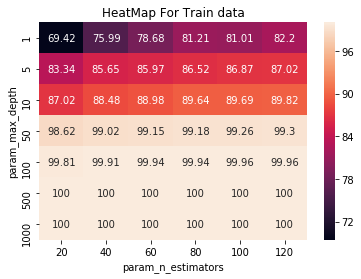

In [47]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

#### HeatMap For CV data

<function matplotlib.pyplot.show(*args, **kw)>

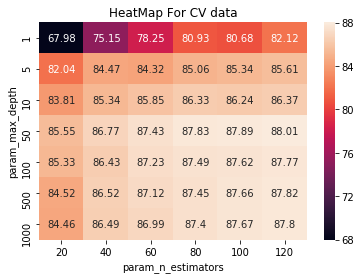

In [48]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[ 3453  3400]
 [    0 53147]]
Test Confusion Matrix
[[  726  4692]
 [   44 34538]]


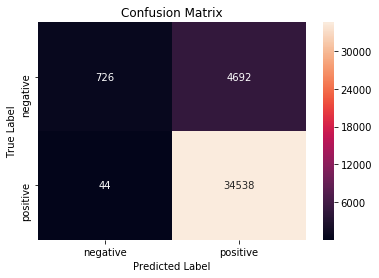

In [55]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

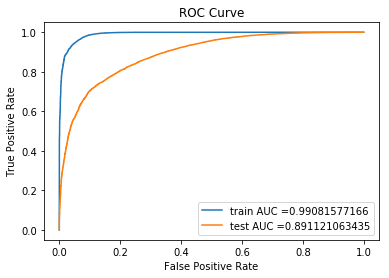

In [53]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [33]:
feature_name = count_vect.get_feature_names()
w = lr.feature_importances_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature = sorted_feature[:-20:-1]

In [34]:
top_feature_names = []
print("Top 20 features :")
print('---------------------')
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))
    top_feature_names.append(feature_name[i])

Top 20 features :
---------------------
disappoint	-->	0.022668
great	-->	0.016591
worst	-->	0.012733
love	-->	0.010487
aw	-->	0.009699
terribl	-->	0.009603
best	-->	0.009516
money	-->	0.009344
horribl	-->	0.009190
wast	-->	0.008735
threw	-->	0.008549
bad	-->	0.007904
refund	-->	0.007623
return	-->	0.007347
would	-->	0.007135
product	-->	0.005779
tast	-->	0.005533
delici	-->	0.005435
good	-->	0.004735


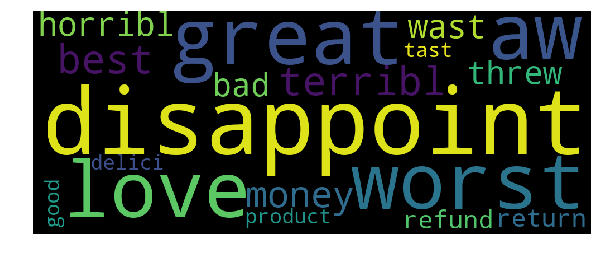

In [37]:
# Please write all the code with proper documentation
# converting list to string
unique_string = (" ").join(top_feature_names)
wordcloud = WordCloud(width = 1000, height = 400, background_color= 'black').generate(unique_string)
plt.figure(figsize = (10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented RandomForestClassifier on Bow Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 120, with a max_depth 50 for Bow Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.
* Displayed WordCloud of top features from Bow vectorizer.

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [57]:
X_train = X_train_tfidf
X_test = X_test_tfidf
estimators = [20, 40, 60, 80, 100, 120]
Depths = [1,5,10,50,100,500,1000]

param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train, y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = RandomForestClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 100
Optimal value of base model: 120
optimal n_estimators 120
optimal max_depth 100


In [58]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model
#Storing it into the dataframe and later plotting it into heatmap

#### HeatMap On Train data

<function matplotlib.pyplot.show(*args, **kw)>

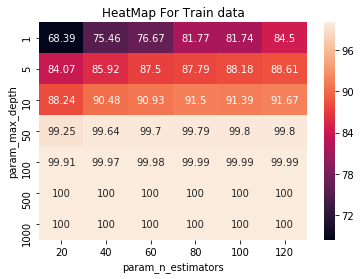

In [59]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

#### HeatMap On CV data

<function matplotlib.pyplot.show(*args, **kw)>

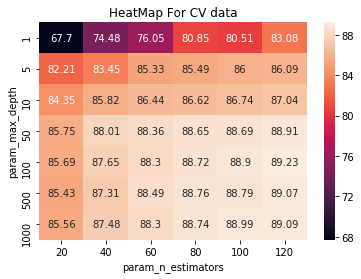

In [60]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

#### ConfusionMatrix

Train Confusion Matrix
[[ 5601  1252]
 [    0 53147]]
Test Confusion Matrix
[[ 1009  4409]
 [  101 34481]]


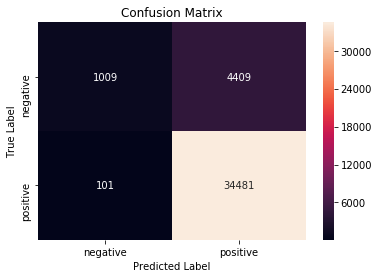

In [61]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### ROC Curve

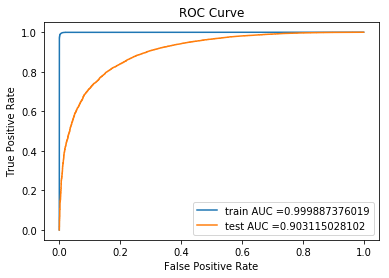

In [62]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [38]:
feature_name = tf_idf_vect.get_feature_names()
w = lr.feature_importances_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature = sorted_feature[:-20:-1]

In [39]:
top_feature_names = []
print("Top 20 features :")
print('---------------------')
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))
    top_feature_names.append(feature_name[i])

Top 20 features :
---------------------
disappoint	-->	0.022668
great	-->	0.016591
worst	-->	0.012733
love	-->	0.010487
aw	-->	0.009699
terribl	-->	0.009603
best	-->	0.009516
money	-->	0.009344
horribl	-->	0.009190
wast	-->	0.008735
threw	-->	0.008549
bad	-->	0.007904
refund	-->	0.007623
return	-->	0.007347
would	-->	0.007135
product	-->	0.005779
tast	-->	0.005533
delici	-->	0.005435
good	-->	0.004735


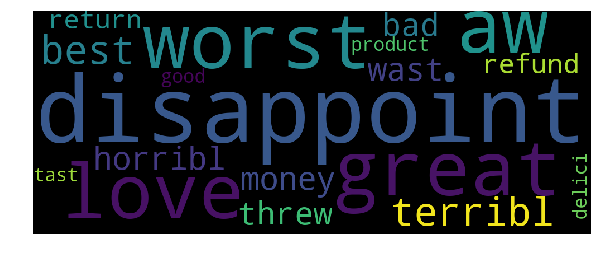

In [40]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# converting list to string
unique_string = (" ").join(top_feature_names)
wordcloud = WordCloud(width = 1000, height = 400, background_color= 'black').generate(unique_string)
plt.figure(figsize = (10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented RandomForestClassifier on TFIDF Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 120, with a max_depth 100 for TFIDF Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.
* Displayed WordCloud of top features from TFIDF vectorizer.

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [65]:
X_train = sent_vectors_train
X_test = sent_vectors_test
estimators = [20, 40, 60, 80, 100, 120]
Depths = [1,5,10,50,100,500,1000]

param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train, y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = RandomForestClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 10
Optimal value of base model: 100
optimal n_estimators 100
optimal max_depth 10


In [66]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model

<function matplotlib.pyplot.show(*args, **kw)>

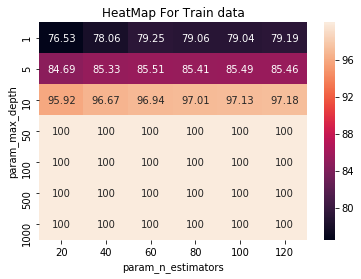

In [67]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

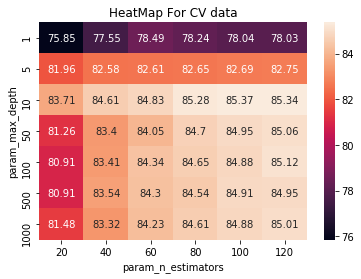

In [68]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[ 1109  5744]
 [   35 53112]]
Test Confusion Matrix
[[  313  5105]
 [  110 34472]]


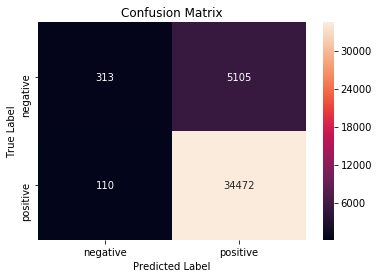

In [69]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

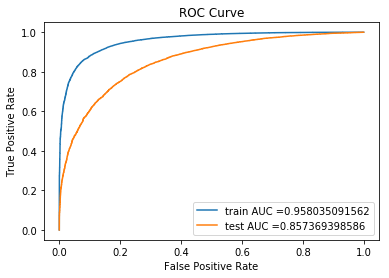

In [70]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()


#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented RandomForestClassifier on AvgW2v Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 100, with a max_depth 10 for AvgW2v Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [71]:
X_train = tfidf_sent_vectors_train
X_test = tfidf_sent_vectors_test
estimators = [20, 40, 60, 80, 100, 120]
Depths = [1,5,10,50,100,500,1000]

param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, pre_dispatch=2)
model.fit(X_train, y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = RandomForestClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 10
Optimal value of base model: 100
optimal n_estimators 100
optimal max_depth 10


In [72]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model

<function matplotlib.pyplot.show(*args, **kw)>

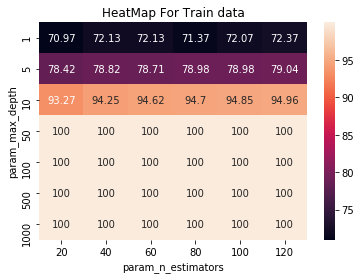

In [73]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

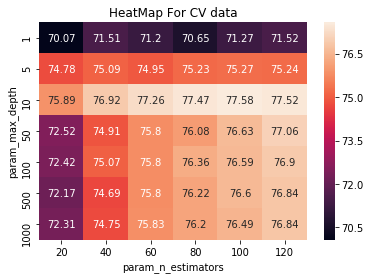

In [74]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[  226  6627]
 [    1 53146]]
Test Confusion Matrix
[[   15  5403]
 [    5 34577]]


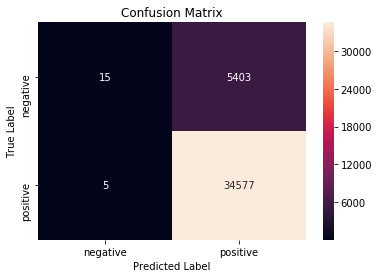

In [75]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

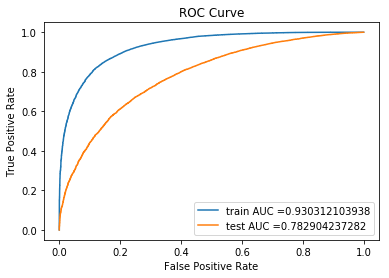

In [76]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented RandomForestClassifier on TFIDFW2V Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 100, with a max_depth 10 for TFIDFW2V Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [36]:
X_train = X_train_bow
X_test = X_test_bow
estimators = [1, 5, 10, 50, 100]
Depths = [2, 4, 6, 9, 11]


param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = xgb.XGBClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(lr, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train, y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = xgb.XGBClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 11
Optimal value of base model: 100
optimal n_estimators 100
optimal max_depth 11


In [37]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model

<function matplotlib.pyplot.show(*args, **kw)>

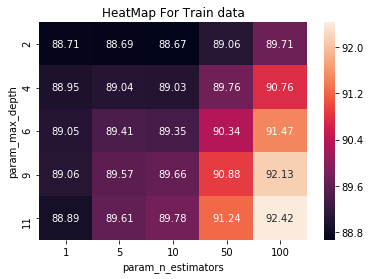

In [38]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

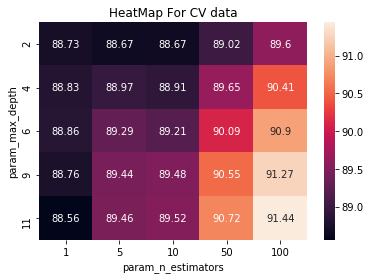

In [39]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[ 3496  3357]
 [  100 53047]]
Test Confusion Matrix
[[ 1829  3589]
 [  335 34247]]


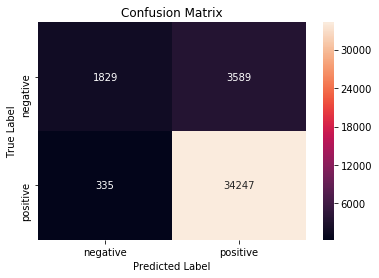

In [41]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

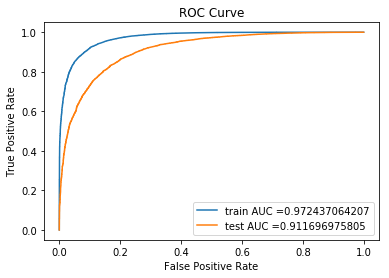

In [42]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented XGBClassifier on Bow Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 100, with a max_depth 11 for Bow Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [43]:
# Please write all the code with proper documentation
X_train = X_train_tfidf
X_test = X_test_tfidf

estimators = [1, 5, 10, 50, 100]
Depths = [2, 4, 6, 9, 11]


param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = xgb.XGBClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(lr, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train, y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = xgb.XGBClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 11
Optimal value of base model: 100
optimal n_estimators 100
optimal max_depth 11


In [44]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model

<function matplotlib.pyplot.show(*args, **kw)>

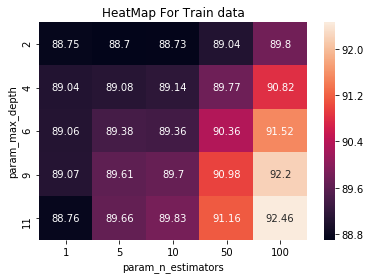

In [45]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

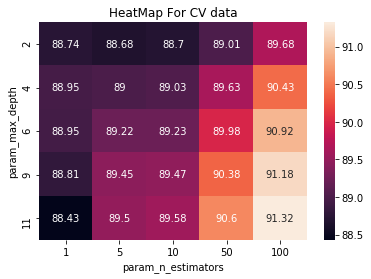

In [46]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[ 3705  3148]
 [   70 53077]]
Test Confusion Matrix
[[ 1754  3664]
 [  298 34284]]


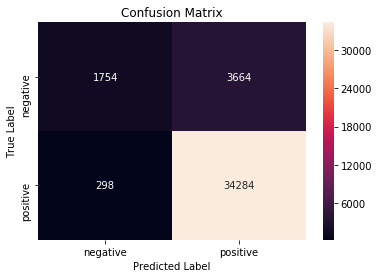

In [47]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

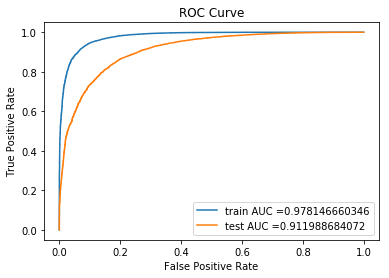

In [48]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented XGBClassifier on TFIDF Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 100, with a max_depth 11 for TFIDF Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [68]:
# Please write all the code with proper documentation
X_train = sent_vectors_train
X_test = sent_vectors_test
estimators = [1, 5, 10, 50, 100]
Depths = [2, 4, 6, 9, 11]


param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = xgb.XGBClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(lr, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(np.array(X_train), y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = xgb.XGBClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(np.array(X_train), y_train)

pred = lr.predict(np.array(X_test))
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

Optimal value of max depth: 4
Optimal value of base model: 100
optimal n_estimators 100
optimal max_depth 4


In [69]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model

<function matplotlib.pyplot.show(*args, **kw)>

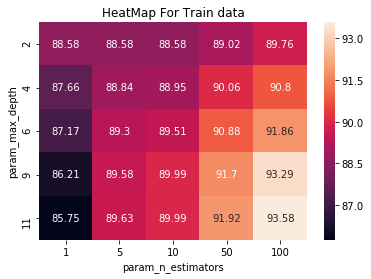

In [70]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

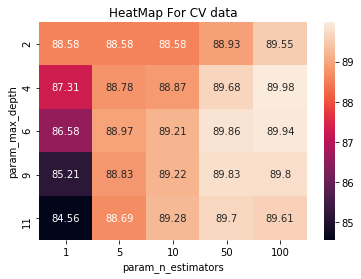

In [71]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[ 1953  4900]
 [  601 52546]]
Test Confusion Matrix
[[ 1319  4099]
 [  550 34032]]


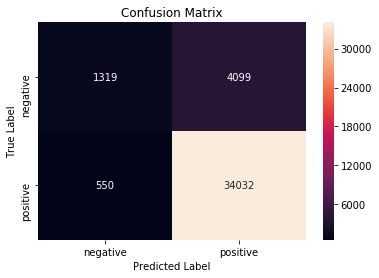

In [72]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

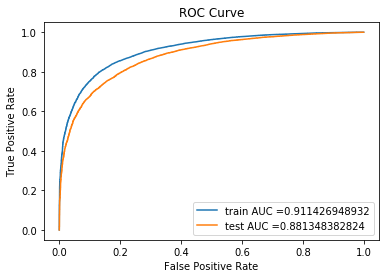

In [73]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented XGBClassifier on AvgW2V Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 100, with a max_depth 4 for AvgW2V Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [74]:
# Please write all the code with proper documentation
X_train = tfidf_sent_vectors_train
X_test = tfidf_sent_vectors_test

estimators = [1, 5, 10, 50, 100]
Depths = [2, 4, 6, 9, 11]


param_grid = {'n_estimators': estimators, 'max_depth':Depths}
lr = xgb.XGBClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(lr, param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(np.array(X_train), y_train)
optimal_depth = model.best_estimator_.max_depth
print("Optimal value of max depth:",optimal_depth)

#optimal value of n_estimators
optimal_estimator = model.best_estimator_.n_estimators
print("Optimal value of base model:",optimal_estimator)

lr = xgb.XGBClassifier(n_estimators=optimal_estimator, max_depth=optimal_depth, n_jobs=-1)
lr.fit(np.array(X_train), y_train)

pred = lr.predict(np.array(X_test))
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)


Optimal value of max depth: 2
Optimal value of base model: 100
optimal n_estimators 100
optimal max_depth 2


In [75]:
dataframe = pd.DataFrame(model.cv_results_) # model.cv_results_ : gives the results after fitting the model

<function matplotlib.pyplot.show(*args, **kw)>

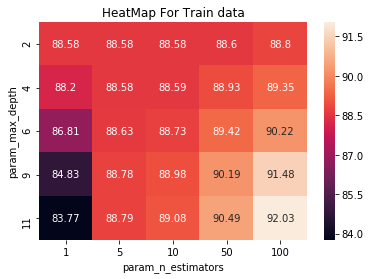

In [76]:
#Train data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For Train data')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

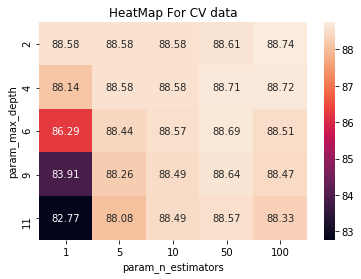

In [77]:
#Cv data Heatmap
import warnings
warnings.filterwarnings("ignore")

max_scores = dataframe.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores  = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('HeatMap For CV data')
plt.show

Train Confusion Matrix
[[   80  6773]
 [   22 53125]]
Test Confusion Matrix
[[   54  5364]
 [   31 34551]]


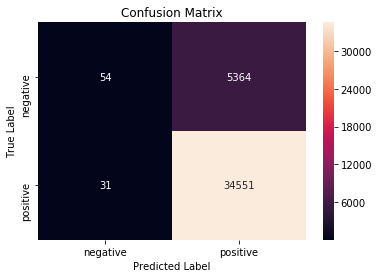

In [78]:
#Confusion Matrix
print("Train Confusion Matrix")
print(confusion_matrix(y_train, lr.predict(X_train)))
print("Test Confusion Matrix")
print(confusion_matrix(y_test, lr.predict(X_test)))
cm_test=confusion_matrix(y_test, lr.predict(X_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_test, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

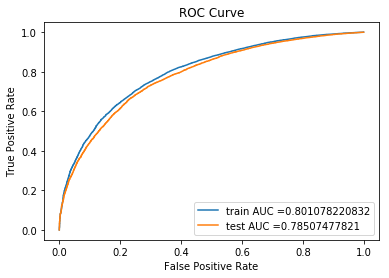

In [79]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

#### Observation
* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* Implemented XGBClassifier on TFIDFW2V Vectorizer, using n_estimators, depths as hyperparameters.
* Observed Optimal estimators 100, with a max_depth 2 for TFIDFW2V Model.
* Above Heatmap displaying AUC Scores for Train and CV data, for optimal n_estimators and max_depth.

# [6] Conclusions

In [81]:
# Please compare all your models using Prettytable library
x =  PrettyTable()
#Adding Field-names
x.field_names = ["Vectorizer", "Model", "Best(estimators)", "Best(max_depth)", "AUC"]

x.add_row(["BOW", "RandomForestClassifier", 120, 50, 0.99])
x.add_row(["TFIDF", "RandomForestClassifier", 120, 100, 0.999])
x.add_row(["AvgW2v", "RandomForestClassifier", 100, 10, 0.88])
x.add_row(["TFIDFW2V", "RandomForestClassifier", 100, 10, 0.885])
x.add_row(["BOW", "XGBClassifier", 100, 11, 0.972])
x.add_row(["TFIDF", "XGBClassifier", 100, 11, 0.987])
x.add_row(["AvgW2v", "XGBClassifier", 100, 4, 0.911])
x.add_row(["TFIDFW2V", "XGBClassifier", 100, 2, 0.801])
print(x)

+------------+------------------------+------------------+-----------------+-------+
| Vectorizer |         Model          | Best(estimators) | Best(max_depth) |  AUC  |
+------------+------------------------+------------------+-----------------+-------+
|    BOW     | RandomForestClassifier |       120        |        50       |  0.99 |
|   TFIDF    | RandomForestClassifier |       120        |       100       | 0.999 |
|   AvgW2v   | RandomForestClassifier |       100        |        10       |  0.88 |
|  TFIDFW2V  | RandomForestClassifier |       100        |        10       | 0.885 |
|    BOW     |     XGBClassifier      |       100        |        11       | 0.972 |
|   TFIDF    |     XGBClassifier      |       100        |        11       | 0.987 |
|   AvgW2v   |     XGBClassifier      |       100        |        4        | 0.911 |
|  TFIDFW2V  |     XGBClassifier      |       100        |        2        | 0.801 |
+------------+------------------------+------------------+-------

* Considered 100K data points out of whole dataset, for both the classifiers(RandomForest, XGBClassifier).
* From the above table observed that TFIDF with RFClassifier and XGBClassifier got good AUC score compare with other models.
* In RandomForest we are using Randomization as a way to reduce Variance.
* Because base learners are low-bias
* since RandomForest are low-bias and reduced variance it is most used & popular bagging algorithm.
* Bagging can reduce variance in a model without impacting the bias.